In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import stan
import arviz as az

import nest_asyncio
nest_asyncio.apply()

In [36]:
# Set global set
global_rng = np.random.default_rng(42)

# Fix true parameters
true_params = {
    'a': 0.9,
    'b': 0.8,
    'c': 0.9,
    'd': 0.7,
    'e': 0.9,
    'f': 0.8,
    'g': 0.4,
    'h': 0.3,
}

a = 0.9
b = 0.8
c = 0.9
d = 0.7
e = 0.9
f = 0.8
g = 0.4
h = 0.3

# Fix true probabilities
num_trials = 120
true_probs = {
    'correct': a * b * c * d * e * f,
    'semantic': a * b * (1 - c) * f,
    'formal': (a * b * c * (1 - d) * f) \
            + (a * b * c * (1 - d) * (1 - f) * g) \
            + (a * b * c * d * (1 - e) * (1 - f) * g) \
            + (a * b * c * d * e * (1 - f) * g),
    'mixed': (a * b * c * d * (1 - e) * f),
    'unrelated': a * (1 - b) +\
                 a * (1 - b) * (1 - f) * h +\
                 a * b * (1 - c) * (1 - f) * h,
    'neologism': (a * b * c * (1 - d) * (1 - f) * (1 - g)) \
                +(a * b * c * d * (1 - e) * (1 - f) * (1 - g)) \
                +(a * b * c * d * e * (1 - f) * (1 - g)),
    'abstruse_neologism': (a * (1 - b) * (1 - f) * (1 - h)) \
                        + (a * b * (1 - c) * (1 - f) * (1 - h)),
    'NA': (1 - a)
}

data = global_rng.multinomial(n=num_trials, pvals=list(true_probs.values()))

In [37]:
data

array([29,  4, 38,  6, 20,  7,  5, 11])

In [38]:
mpt_model_code = """
data {
  int<lower=1> N;
  int<lower=1> K;
  array[K] int<lower=0, upper=N> freqs;
}

parameters {
  real<lower=0, upper=1> a;
  real<lower=0, upper=1> b;
  real<lower=0, upper=1> c;
  real<lower=0, upper=1> d;
  real<lower=0, upper=1> e;
  real<lower=0, upper=1> f;
  real<lower=0, upper=1> g;  
  real<lower=0, upper=1> h;
}

transformed parameters {
  simplex[K] theta;
  theta[1] = a * b * c * d * e * f;
  theta[2] = a * b * (1 - c) * f;
  theta[3] = (a * b * c * (1 - d) * f) \
           + (a * b * c * (1 - d) * (1 - f) * g) \
           + (a * b * c * d * (1 - e) * (1 - f) * g) \
           + (a * b * c * d * e * (1 - f) * g);
  theta[4] = (a * b * c * d * (1 - e) * f);
  theta[5] = a * (1 - b) * f\
           + a * (1 - b) * (1 - f) * h \
           + a * b * (1 - c) * (1 - f) * h;
  theta[6] = (a * b * c * (1 - d) * (1 - f) * (1 - g)) \
           + (a * b * c * d * (1 - e) * (1 - f) * (1 - g)) \
           + (a * b * c * d * e * (1 - f) * (1 - g));
  theta[7] = (a * (1 - b) * (1 - f) * (1 - h)) \
           + (a * b * (1 - c) * (1 - f) * (1 - h));
  theta[8] = (1 - a);
}

model {
  target += beta_lpdf(a | 1, 1);
  target += beta_lpdf(b | 1, 1);
  target += beta_lpdf(c | 1, 1);
  target += beta_lpdf(d | 1, 1);
  target += beta_lpdf(e | 1, 1);
  target += beta_lpdf(f | 1, 1);
  target += beta_lpdf(g | 1, 1);
  target += beta_lpdf(h | 1, 1);
  target += multinomial_lpmf(freqs | theta);
}

generated quantities{
  array[K] int pred_freqs;
  pred_freqs = multinomial_rng(theta, N);
}
"""

In [39]:
# Prepare data
stan_dict = {
    'freqs': data,
    'N': num_trials,
    'K': data.shape[0]
}


# Compile model
posterior = stan.build(mpt_model_code, data=stan_dict, random_seed=42)


# Sample (i.e., inverse inference)
fit = posterior.sample(num_chains=4, num_samples=1000, num_warmup=1000)

Building: found in cache, done.
Sampling:   0%
Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 2.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.27 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.28 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.32 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.19 seconds.
  Adjust your expectations accordingly!


In [52]:
az.summary(fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.901,0.027,0.848,0.946,0.000,0.000,3522.0,2162.0,1.0
b,0.789,0.044,0.704,0.871,0.001,0.001,3063.0,2211.0,1.0
c,0.915,0.038,0.843,0.978,0.001,0.001,2521.0,2112.0,1.0
d,0.663,0.147,0.439,0.960,0.004,0.003,1661.0,1508.0,1.0
e,0.811,0.063,0.700,0.930,0.001,0.001,3749.0,2471.0,1.0
f,0.672,0.133,0.432,0.888,0.003,0.002,1528.0,2487.0,1.0
g,0.653,0.189,0.268,0.929,0.005,0.003,1755.0,1753.0,1.0
h,0.439,0.222,0.006,0.767,0.005,0.004,1990.0,1952.0,1.0
theta[0],0.226,0.036,0.160,0.294,0.001,0.000,4490.0,3633.0,1.0
theta[1],0.039,0.017,0.010,0.070,0.000,0.000,3361.0,2199.0,1.0


<Axes: xlabel='pred_freqs.4', ylabel='Count'>

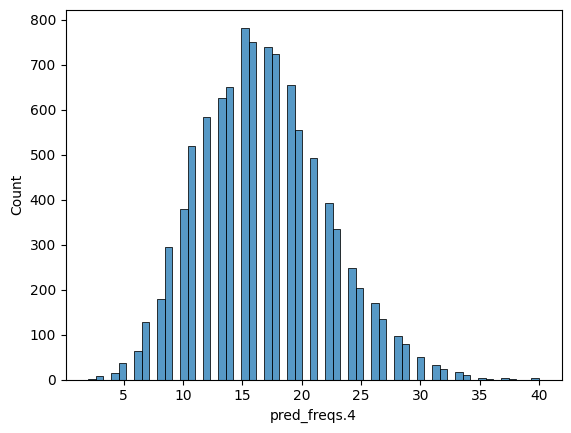

In [16]:
sns.histplot(fit.to_frame().iloc[:, -1])

## Global Parameter Recovery Study

In [60]:
truth = list(true_params.values())
print(truth)

[0.9, 0.8, 0.9, 0.7, 0.9, 0.8, 0.4, 0.3]


In [81]:
from sklearn.metrics import root_mean_squared_error

truth = list(true_params.values())
start = 10
end = 2500
step = 10
errors = np.zeros((int((end - start) / step), 2) )

for idx, num_samples in enumerate(range(start, end, step)):
    print(f"Sampling for {num_samples} samples")
    fit = posterior.sample(num_chains=4, num_samples=num_samples, num_warmup=1000)
    df = az.summary(fit).head(8).iloc[:, 0].to_numpy()
    errors[idx] = [num_samples, root_mean_squared_error(np.array(truth), df)]
    

Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.2 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.2 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.23 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.13 seconds.
  Adjust your expectations accordingly!
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 1.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.14 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.4e-

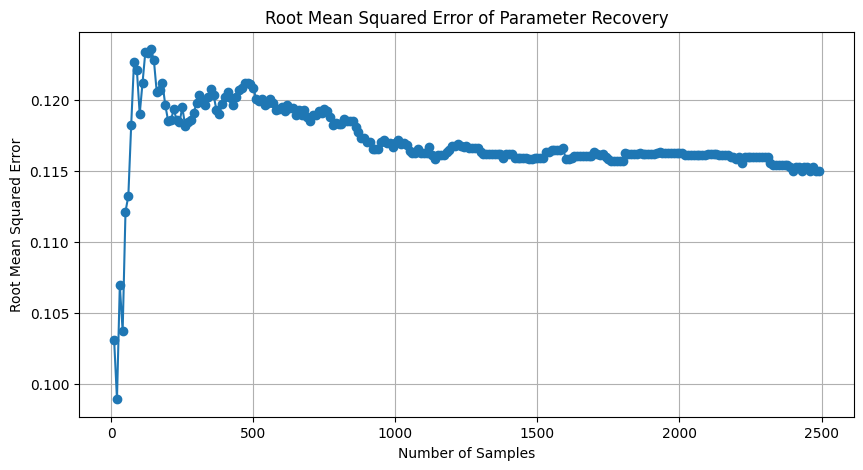

In [83]:
# Plotting the data
plt.figure(figsize=(10, 5))
plt.plot(errors[:, 0], errors[:, 1], marker='o')

# Labeling axes
plt.xlabel('Number of Samples')
plt.ylabel('Root Mean Squared Error')

# Adding title
plt.title('Root Mean Squared Error of Parameter Recovery')

# Show grid
plt.grid(True)

# Show the plot
plt.show()